In [1]:
using Pkg
Pkg.activate(joinpath(Pkg.devdir(),"TaskGraphs"));

In [2]:
using TaskGraphs

┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/TaskGraphs/apcwx.ji for TaskGraphs [6635cb54-791c-11e9-2805-8512ad3937f9]
└ @ Base loading.jl:1190


In [3]:
using CRCBS
using LightGraphs, MetaGraphs
using LinearAlgebra
using DataStructures
# using JuMP, MathOptInterface
# using Gurobi
using TOML
using Random

using GraphUtils
using DataFrames

In [4]:
# include(joinpath(dirname(pathof(TaskGraphs)),"..","test","notebooks","render_tools.jl"));

In [5]:
using PGFPlots
using Printf

┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/PGFPlots/XxINN.ji for PGFPlots [3b7a836e-365b-5785-a47d-02c71176b4aa]
└ @ Base loading.jl:1190


# Display experimental results

In [6]:
function construct_replanner_result_dataframe(problem_dir,results_dir,N_problems)
    config_df = construct_config_dataframe(problem_dir,N_problems,:replanning_config,(dir,id)->joinpath(dir,string("stream",id,"/stream_config.toml")))
    modes = [:replanning]
    Dict(
        mode => join(config_df,
            construct_result_dataframe(mode, problem_dir,results_dir,N_problems,(dir,mode,id)->joinpath(dir,string("stream",id,"/results.toml"))),
            on = :problem_id, kind = :inner) for mode in modes
    )
end

construct_replanner_result_dataframe (generic function with 1 method)

In [7]:
function plot_histories(df_list::Vector;
        y_key=:makespans,
        x_key=:arrival_time,
        m_key=:M,
        m_vals=sort(intersect([unique(df[m_key]) for df in df_list]...)),
        n_key=:arrival_interval,
        n_vals=sort(intersect([unique(df[n_key]) for df in df_list]...)),
        opt_key=:optimal,
        size=4.5pt,
        shape=Shape.xcross,
        geom1=Geom.line,
        geom2=Geom.point,
        geom3=Geom.point,
        scale=Scale.y_log10(format=:plain),
        ymin=minimum(df[y_key]),
        ymax=maximum(df[y_key]),
        xlabel=string("Δt = ",n_vals...),
        ylabel=string("M = ",m_vals...),
        color_scale = Scale.color_discrete_hue(),
        colors_vec = color_scale.f(length(df_list)),
        ytick_show=false,
        plot_padding=[2mm],
    )
    
    
    ylabel = ytick_show ? ylabel : ""
    
    layers = []
    for (i,m_val) in enumerate(m_vals)
        for (j,n_val) in enumerate(n_vals)
            for (df,color) in zip(df_list,colors_vec)
                df_cut = df[(df[m_key] .== m_val).*(df[n_key] .== n_val),:]
                for k in 1:nrow(df_cut)
                    y_arr = df_cut[y_key][k]
                    x_arr = collect(1:length(y_arr))
                    # x_arr = df_cut[x_key][k]
                    opt_vals = df_cut[opt_key][k] # tracks whether the fall back was employed
                    
                    idx = findfirst(y_arr .< 0)
                    idx = idx == nothing ? length(y_arr) : idx-1
                    # Overall trend
                    push!(layers,layer(x=x_arr[1:idx], y=y_arr[1:idx], 
                            geom1, Theme(default_color=color,key_position=:none)))
                    # Timeouts
                    if idx < length(y_arr)
                        # End points
                        push!(layers,layer( x=[x_arr[idx]],y=[y_arr[idx]],
                                shape=[shape],size=[size],Geom.point,Theme(default_color=color,key_position=:none)))
                        idx -= 1 # decrement so that the final point is not covered twice
                    end
                    tmidxs=findall(.~opt_vals[1:idx])
                    push!(layers,layer( x=x_arr[tmidxs],y=y_arr[tmidxs], 
                            Geom.point, Theme(default_color=color,key_position=:none)))
                end
            end
        end
    end
    plot(
        layers...,
        scale,
        Coord.cartesian(ymin=ymin, ymax=ymax),
        Theme(
            key_position=:none,
            plot_padding=[2mm],
            ),
        Guide.xlabel(xlabel),
        Guide.yticks(ytick_show, :auto, :horizontal),
        Guide.ylabel(ylabel,:vertical),
    )
end

plot_histories (generic function with 1 method)

In [21]:
function plot_histories_pgf(df_list::Vector;
        y_key=:makespans,
        x_key=:arrival_time,
        m_key=:M,
        m_vals=sort(intersect([unique(df[m_key]) for df in df_list]...)),
        n_key=:arrival_interval,
        n_vals=sort(intersect([unique(df[n_key]) for df in df_list]...)),
        opt_key=:optimal,
#         ymin=minimum(df[y_key]),
#         ymax=maximum(df[y_key]),
        xlabel=string("\$\\Delta t = ",n_vals...,"\$"),
        ylabel=string("M = ",m_vals...),
        colors=["red","blue","black","brown"],
        ytick_show=false,
    )
    
    
    ylabel = ytick_show ? ylabel : ""
    
    layers = []
    for (i,m_val) in enumerate(m_vals)
        for (j,n_val) in enumerate(n_vals)
            for (df,color) in zip(df_list,colors)
                df_cut = df[(df[m_key] .== m_val).*(df[n_key] .== n_val),:]
                style=string(color,",solid, mark options={solid,fill=",color,"}")
                for k in 1:nrow(df_cut)
                    y_arr = df_cut[y_key][k]
                    x_arr = collect(1:length(y_arr))
                    # x_arr = df_cut[x_key][k]
                    opt_vals = df_cut[opt_key][k] # tracks whether the fall back was employed
                    
                    idx = findfirst(y_arr .< 0)
                    idx = idx == nothing ? length(y_arr) : idx-1
                    # Overall trend
                    push!(layers,
                        Plots.Linear(x_arr[1:idx], y_arr[1:idx], style=style, mark="none")
                    )
                    # Timeouts
                    if idx < length(y_arr)
                        # End points
                        push!(layers,
                            Plots.Linear([x_arr[idx]], [y_arr[idx]], mark="o", style=style, onlyMarks=true, )
                        )
                        idx -= 1 # decrement so that the final point is not covered twice
                    end
                    tmidxs=findall(.~opt_vals[1:idx])
                    if length(tmidxs) > 0
                        push!(layers,
                            Plots.Linear(x_arr[tmidxs], y_arr[tmidxs], style=style, onlyMarks=true, mark="x")
                        )
                    end
                end
            end
        end
    end
    Axis(
        [layers...],ymode="log",xlabel=xlabel
    )
end

plot_histories_pgf (generic function with 1 method)

In [9]:
# set_default_plot_size(28cm,12cm)

In [16]:
base_problem_dir, base_results_dir, solver_configs, _, _, _ = get_replanning_config_2();
# base_dir            = joinpath(EXPERIMENT_DIR,"replanning")
base_dir            = joinpath("/scratch/task_graphs_experiments","replanning/long_problems")
base_problem_dir    = joinpath(base_dir,"problem_instances")
base_results_dir    = joinpath(base_dir,"results")
problem_dir     = base_problem_dir
N_problems = 36

df_list = []
for solver_config in solver_configs
    replan_model = get(solver_config,:replan_model,  MergeAndBalance())
    fallback_model  = get(solver_config,:fallback_model,ReassignFreeRobots())
    results_dir     = get(solver_config,:results_dir,   joinpath(
        base_results_dir, string(typeof(replan_model),"-",typeof(fallback_model))))
    df_dict = construct_replanner_result_dataframe(problem_dir,results_dir,N_problems);
    push!(df_list,df_dict[:replanning])
end

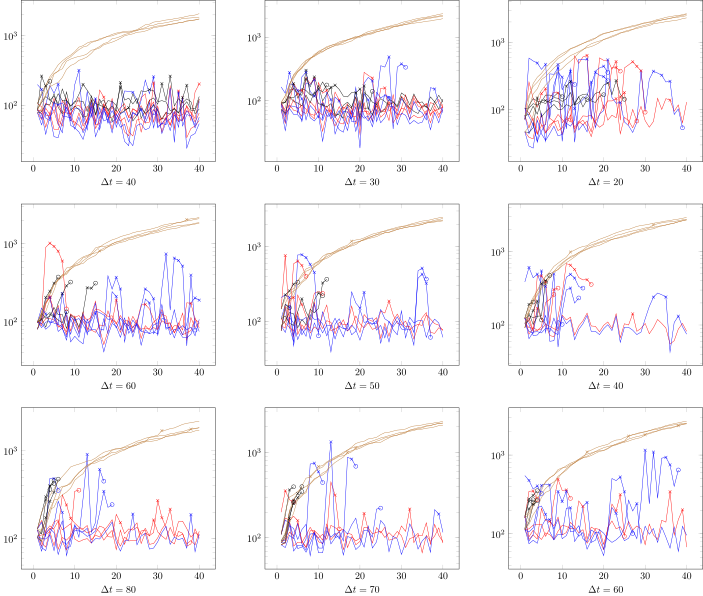

In [23]:
# set_default_plot_size(28cm,24cm)

# df = df_dict[:replanning]
# ymin=1.35
# ymax=3.5
# show_y_ticks=[true,false,false]
# title(
# vstack(
#     hstack([plot_histories(df_list;m_vals=[10],n_vals=[dt],ymin=ymin,ymax=ymax,ytick_show=yshow) for (dt,yshow) in zip([40,30,20],show_y_ticks)]...),
#     hstack([plot_histories(df_list;m_vals=[20],n_vals=[dt],ymin=ymin,ymax=ymax,ytick_show=yshow) for (dt,yshow) in zip([60,50,40],show_y_ticks)]...),
#     hstack([plot_histories(df_list;m_vals=[30],n_vals=[dt],ymin=ymin,ymax=ymax,ytick_show=yshow) for (dt,yshow) in zip([80,70,60],show_y_ticks)]...),
# ),
#     "Project makespan vs. index",
# )
g = GroupPlot(3, 3, groupStyle = "horizontal sep = 1.75cm, vertical sep = 1.5cm")
for (m,n_vals) in [(10,[40,30,20]),(20,[60,50,40]),(30,[80,70,60])]
    for n in n_vals
        push!(g,plot_histories_pgf(df_list;m_vals=[m],n_vals=[n]))
    end
end
g

In [ ]:
big_font=14pt
small_font=12pt
latex_fonts = Theme(major_label_font="CMU Serif", major_label_font_size=big_font,
                minor_label_font="CMU Serif", minor_label_font_size=small_font,
                key_title_font="CMU Serif", key_title_font_size=small_font,
                key_label_font="CMU Serif", key_label_font_size=small_font)

pl1=vstack(
    [compose(context(0, 0, 9.4cm, 8cm), render(
                plot_histories(df_list;m_vals=[m],n_vals=[dt],ymin=ymin,ymax=ymax,ytick_show=true
            ))) for (m,dt) in zip([10,20,30],[40,60,80])]...
)
pl2=vstack(
    [compose(context(0, 0, 8cm, 8cm), render(
                plot_histories(df_list;m_vals=[m],n_vals=[dt],ymin=ymin,ymax=ymax,ytick_show=false
            ))) for (m,dt) in zip([10,20,30],[30,50,70])]...
)
pl3=vstack(
    [compose(context(0, 0, 8cm, 8cm), render(
                plot_histories(df_list;m_vals=[m],n_vals=[dt],ymin=ymin,ymax=ymax,ytick_show=false
            ))) for (m,dt) in zip([10,20,30],[20,40,60])]...
)
pl = hstack(pl1,pl2,pl3)

In [ ]:
using PGFPlots
using Printf

using Random
discretizations = 
           [:default, # use PGFPlots for small data sizes and :auto for large
            :pgfplots, # use the PGFPlots histogram function (uses nbins, which defaults to 10)
            :specified, # use Discretizers.jl but with the specified number of bins (which defaults to 10)
            :auto, # max between :fd and :sturges. Good all-round performance
            :fd, # Freedman Diaconis Estimator, robust
            :sturges, # R's default method, only good for near-Gaussian data
            :sqrt, # used by Excel and others for its simplicity and speed
            :doane, # improves Sturges’ for non-normal datasets.
            :scott, # less robust estimator that that takes into account data variability and data size.
            ]

Random.seed!(0)
data = [randn(500).*1.8 .+ -5;
        randn(2000).*0.8 .+ -4;
        randn(500).*0.3 .+ -1;
        randn(1000).*0.8 .+ 2;
        randn(500).*1.5 .+ 4;
       ]
data = filter!(x->-15.0 <= x <= 15.0, data)

g = GroupPlot(3, 3, groupStyle = "horizontal sep = 1.75cm, vertical sep = 1.5cm")
for discretization in discretizations
    push!(g, Axis(Plots.Histogram(data, discretization=discretization), ymin=0, title=string(discretization)))
end
g

